## Offshore wind resource sparse sampling using Gaussian Mixture Models

This notebook is an exemple for the implementation of Gaussian Mixture Models for the sparse sampling of offshore wind resource. Exemple is shown on the Mediterranean Sea

In [1]:
from data.EOF import compute_EOFs, eofs_2d_to_1d
from data.read_data import read_from_nc_files, process_lat_lon, process_time_index
from plots.map_plots import plot_EOF, plot_sensors_locations
from models.QR_pivot import qr_pivots
from models.GMM import fit_gmm_and_extract_centroids
import xarray as xr
import numpy as np
import pandas as pd
from models.EOF_extrema import select_eofs_exrtrema
import scipy
from sklearn import mixture
import random


#### Read and prepare data

Read data from nc files, mask land points and compute the EOFs

In [2]:
#Read data from file.
years = ['2016', '2017', '2018']
wind_speed, df_med, lat, lon, mask = read_from_nc_files(years)
time_index = process_time_index(years)
df_med.index = time_index

idx_train = time_index.year < 2018
idx_test = time_index.year >= 2018

In [3]:
lat_flat, lon_flat, mask_flat, df_latlon = process_lat_lon(lat, lon, mask)

In [4]:
#Compute EOFs
EOF_results = compute_EOFs(wind_speed['u'], wind_speed['v'], lat, lon, mask, idx_train, N_eofs = 10)

In [6]:
EOFs_u = EOF_results['EOFs_u']
EOFs_v = EOF_results['EOFs_v']
EOFs = np.vstack((EOFs_u, EOFs_v))
V_svd = pd.concat([pd.DataFrame(EOFs_u.T), pd.DataFrame(EOFs_v.T)], axis = 1)

Visualize EOFs 

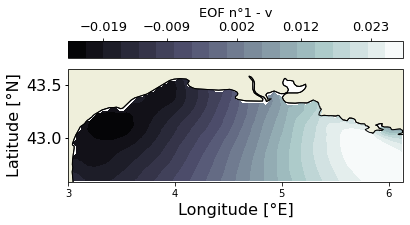

In [7]:
plot_EOF(EOFs_v, lat_flat, lon_flat, 1, 'v')

### Compute sensors placement from EOFs extrema

From Yildirim et al. (2009), selection of the EOFs extrema as salient points for sparse sampling - manual process

In [8]:
#Extrema manually selected to avoid repetitions. For EOFs from 1 to 5 for u and v, the maximum and minimum of the EOFs can be selected

#Selected extrema on the Mediterranean Sea
extrema_u_med = {1 : {'max' : 1, 'min' : 1}, 2 : {'max' : 1, 'min' : 0}, 3 : {'max' : 1, 'min' : 0}, 4 : {'max' : 1, 'min' : 0}, 5 : {'max' : 0, 'min' : 0}}
extrema_v_med = {1 : {'max' : 1, 'min' : 1}, 2 : {'max' : 0, 'min' : 1}, 3 : {'max' : 1, 'min' : 1}, 4 : {'max' : 0, 'min' : 0}, 5 : {'max' : 0, 'min' : 0}}
extrema_med = {'u' : extrema_u_med, 'v' : extrema_v_med}
n_sensors = 7

In [9]:
eofs_extrema_sensors_tot = select_eofs_exrtrema(EOFs_u, EOFs_v, extrema_med)
eofs_extrema_sensors = eofs_extrema_sensors_tot[:n_sensors]

### Compute QR pivoting sparse sampling

From (.......), selection of the pivots from the QR decomposition of the EOFs matrix as salient points for sparse sampling

In [10]:
qr_pivots_sensors = qr_pivots(EOFs, n_sensors)

### Compute Gaussian Mixture Model sparse sampling

The proposed model uses unsupervised clustering using Gaussian Mixture Models to perform sparse sampling. After fitting a GMM on the EOFs data, the clusters' centroids are selected as sensors locations

In [11]:
gmm_sensors = fit_gmm_and_extract_centroids(EOFs, n_clusters = n_sensors, random_state = random.randint(0, 100))

Visualize derived sensors positions

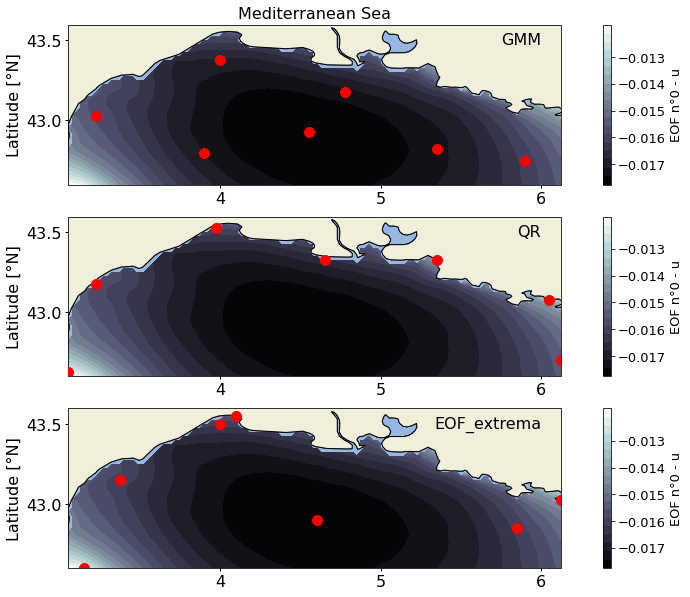

In [12]:
idx_sensors = {'GMM': gmm_sensors, 'QR': qr_pivots_sensors, 'EOF_extrema': eofs_extrema_sensors}
plot_sensors_locations(lon_flat, lat_flat, idx_sensors, EOFs, n_eof = 0)

### Scoring

The reconstruction error is defined as the Root Mean Squared Error of the reconstructed wind field from limited measurements

In [15]:
n_inputs_points = df_latlon.shape[0]

for idx in gmm_sensors : 
    gmm_sensors = np.append(gmm_sensors, idx + n_inputs_points)
    
Yu = pd.DataFrame(np.dot(df_med.iloc[:, :3571], EOFs_u.T))
Yv = pd.DataFrame(np.dot(df_med.iloc[:, 3571:], EOFs_v.T))

df_output = pd.concat([Yu, Yv], axis = 1)
df_output.index = df_med.index
df_input = df_med.iloc[:, qr_pivots_sensors]

idx_train = time_index.month < 10
idx_test = time_index.month >= 10

Y_obs_test = df_input.iloc[idx_test, :]
Y_obs_train = df_input.iloc[idx_train, :]

a_real_train = df_output.iloc[idx_train, :]
a_real_test = df_output.iloc[idx_test, :]

Xtest = df_input.iloc[idx_test, :]
Xtrain = df_input.iloc[idx_train, :]

Ytrain = df_output.iloc[idx_train, :]
Ytest = df_output.iloc[idx_test, :]

In [16]:
C_gamma = np.zeros((7, 3571))
for i in range(7):
    C_gamma[i, gmm_sensors[i]] = 1

In [17]:

def score_reconstructed(Yt, Yp, V, Npc, mean_u=0, mean_v=0, std_u=1, std_v=1):
    from sklearn.metrics import mean_squared_error
    NpcT = int(Yt.shape[1]/2)
    Ytestunorm = np.dot(Yt[:, :NpcT], V[:, :NpcT].T)
    Ytestvnorm = np.dot(Yt[:, NpcT:], V[:, NpcT:].T)
    
    Ytestnorm = np.hstack((Ytestunorm, Ytestvnorm))
    umagtest = np.sqrt(Ytestunorm**2 + Ytestvnorm**2)
    
    Ypredunorm = np.dot(Yp[:, :Npc], V[:, :Npc].T)
    Ypredvnorm = np.dot(Yp[:, Npc:], V[:, NpcT:Npc + NpcT].T)
    Ypredrecnorm = np.hstack((Ypredunorm, Ypredvnorm))

    umagpred = np.sqrt(Ypredunorm**2 + Ypredvnorm**2)

    err = mean_squared_error(umagtest, umagpred, squared = False)
    err_uv = mean_squared_error(Ypredrecnorm, Ytestnorm, squared = False)

    return err, err_uv




def score_reconstructed_max_mean(Yt, Yp, V, LAT, LON, Npc, mean_u=0, mean_v=0, std_u=1, std_v=1):
    from sklearn.metrics import mean_squared_error
    NpcT = int(Yt.shape[1]/2)
    Ytestunorm = np.dot(Yt[:, :NpcT], V[:, :NpcT].T)
    Ytestunorm = (Ytestunorm - mean_u)/std_u
    Ytestvnorm = np.dot(Yt[:, NpcT:], V[:, NpcT:].T)
    Ytestvnorm = (Ytestvnorm - mean_v)/std_v
    
    Ytestnorm = np.hstack((Ytestunorm, Ytestvnorm))
    umagtest = np.sqrt(Ytestunorm**2 + Ytestvnorm**2)
    
    Ypredunorm = np.dot(Yp[:, :Npc], V[:, :Npc].T)
    Ypredunorm = (Ypredunorm - mean_u)/std_u
    Ypredvnorm = np.dot(Yp[:, Npc:], V[:, NpcT:Npc + NpcT].T)
    Ypredvnorm = (Ypredvnorm - mean_v)/std_v
    Ypredrecnorm = np.hstack((Ypredunorm, Ypredvnorm))
    umagpred = np.sqrt(Ypredunorm**2 + Ypredvnorm**2)
    max_umagpred = umagpred.max(axis = 0)
    max_umagtest = umagtest.max(axis = 0)
    err_umax = mean_squared_error(max_umagpred, max_umagtest, squared = False)
    mean_umagpred = umagpred.mean(axis = 0)
    mean_umagtest = umagtest.mean(axis = 0)
    err_umean = mean_squared_error(mean_umagpred, mean_umagtest, squared = False)

    
    err = mean_squared_error(umagtest, umagpred, squared = False)
    err_uv = mean_squared_error(Ypredrecnorm, Ytestnorm, squared = False)
    umagi = []
    df_umag = []
#     rmse_umag = (umagpred - umagtest)**2
#     rmse_umag = np.sqrt(rmse_umag.mean(axis = 0))
#     minylat = min(LAT)
#     maxylat = max(LAT) + 0.025
#     minxlon = min(LON)
#     maxxlon = max(LON) + 0.025
#     ylat = np.arange(minylat, maxylat, 0.025)
#     xlon = np.arange(minxlon, maxxlon, 0.025)
#     XLON, YLAT = np.meshgrid(xlon, ylat)
    
#     df_umag = pd.DataFrame({'umag' : rmse_umag, 'lat' : LAT, 'lon' : LON})
#     umagi = pd.pivot_table(df_umag, values = 'umag', index = 'lat', columns = 'lon')
    
    return err, err_uv, umagi, df_umag, err_umax, err_umean

def LeastSquares(X, Y, Xt, Yt, V, LAT, LON, Npc=10, nrmse = False): 
    X = X
    beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T),Y)
    Ypred = np.dot(beta_hat.T,  Xt.T).T
    errRecons, errRecons_uv = score_reconstructed(Yt, Ypred, V, LAT, LON,10)
    return errRecons_uv, Ypred

def LeastSquares_max_mean(X, Y, Xt, Yt, V, LAT, LON, Npc=10, nrmse = False): 
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T),Y)
    Ypred = np.dot(beta_hat.T, np.hstack((np.ones((Xt.shape[0], 1)), Xt)).T).T
    mean_u_train = np.dot(Y[:, :Npc], V[:, :Npc].T).mean()
    mean_v_train = np.dot(Y[:, Npc:], V[:, Npc:].T).mean()
    std_u_train = np.dot(Y[:, :Npc], V[:, :Npc].T).std()
    std_v_train = np.dot(Y[:, Npc:], V[:, Npc:].T).std()
    if nrmse : 
        errRecons, errRecons_uv, umagi, df_umag, err_umax, err_umean = score_reconstructed_max_mean(Yt, Ypred, V, LAT, LON,10, mean_u_train,mean_v_train ,std_u_train,std_v_train)
    else:
        errRecons, errRecons_uv, umagi, df_umag, err_umax, err_umean = score_reconstructed_max_mean(Yt, Ypred, V, LAT, LON,10)
    return errRecons_uv, Ypred, umagi, err_umax, err_umean

In [18]:
def LeastSquares_reconstruction(Y_obs_train, a_train, Y_obs_test): 
    Y_obs_train = np.hstack((np.ones((Y_obs_train.shape[0], 1)), Y_obs_train))
    beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(Y_obs_train.T, Y_obs_train)), Y_obs_train.T),a_train)
    a_recons = np.dot(beta_hat.T, np.hstack((np.ones((Y_obs_test.shape[0], 1)), Y_obs_test)).T).T
    return a_recons

def inverse_reconstruction(Y_obs_test, C_gamma, EOFs):
    return np.dot(np.linalg.pinv(np.dot(C_gamma, EOFs)), Y_obs_test.T)


In [19]:
errLS_uv, YpredLS, dfumagLS = LeastSquares(Xtrain.values, Ytrain.values, Xtest.values, Ytest.values, V_svd.values, lat_flat, 
                                            lon_flat, nrmse = False)

In [33]:
C_gamma2 = np.vstack((C_gamma, C_gamma))

(20, 14)

In [90]:
# a_recons_inverse_u = inverse_reconstruction(Y_obs_test.iloc[:, :7], C_gamma, EOFs[:10, :].T)
# a_recons_inverse_v = inverse_reconstruction(Y_obs_test.iloc[:, 7:], C_gamma, EOFs[10:, :].T)
# Xu_recons_inverse = np.dot(EOFs[:10, :].T, a_recons_inverse_u)
# Xv_recons_inverse = np.dot(EOFs[10:, :].T, a_recons_inverse_v)
# X_recons_inverse = np.vstack((Xu_recons_inverse, Xv_recons_inverse))
a_reconstrain = np.dot(np.linalg.pinv(np.dot(C_gamma2, EOFs.T)), Y_obs_train.T)

a_recons = np.dot(np.linalg.pinv(np.dot(C_gamma2, EOFs.T)), Y_obs_test.T)
Yrecons_u = np.dot(EOFs[:10, :].T, a_recons[:10, :])
Yrecons_v = np.dot(EOFs[10:, :].T, a_recons[10:, :])

Yrecons = np.vstack((Yrecons_u, Yrecons_v)).T

beta_hat = np.dot(np.dot(np.linalg.inv(np.dot(Y_obs_train.T, Y_obs_train)), Y_obs_train.T), Ytrain)
a_LS = np.dot(beta_hat.T,  Y_obs_test.T)
Y_LS_u = np.dot(EOFs[:10, :].T, a_LS[:10, :])
Y_LS_v = np.dot(EOFs[10:, :].T, a_LS[10:, :])
Y_LS = np.vstack((Y_LS_u, Y_LS_v)).T

In [86]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_LS, Ytest, squared = False)

0.8307232

In [71]:
a_recons_LS = LeastSquares_reconstruction(Y_obs_train, a_real_train, Y_obs_test)
X_recons_LS = np.dot(V_svd, a_recons_LS.T)

In [81]:
Ytest.shape

(6240, 7142)

In [45]:
# Xu_real = np.dot(V_svd.iloc[:, :10], a_real_test.iloc[:, :10].T)
# Xv_real = np.dot(V_svd.iloc[:, 10:], a_real_test.iloc[:, 10:].T)
# Xreal = np.vstack((Xu_real, Xv_real))

Ytestu_real = np.dot(a_real_test.iloc[:, :10], V_svd.iloc[:, :10].T)
Ytestv_real = np.dot(a_real_test.iloc[:, 10:], V_svd.iloc[:, 10:].T)

Ytest_real = np.hstack((Ytestu_real, Ytestv_real))

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Yrecons, Ytest, squared = False)

5.95720663133455

In [82]:
np.sqrt(((X_recons_LS - np.dot(V_svd, a_real_test.T))**2).mean())

4.187868

In [ ]:
n_inputs_points = df_latlon.shape[0]

for idx in qr_pivots_sensors : 
    qr_pivots_sensors = np.append(qr_pivots_sensors, idx + n_inputs_points)

df_input = df_med.iloc[:, qr_pivots_sensors]
Xtrain = df_input[df_input.index.year < 2018]
Xtest = df_input[df_input.index.year == 2018]
Ytrain = df_output[df_output.index.year < 2018]
Ytest = df_output[df_output.index.year == 2018]
errLS_uv_extrema, YpredLS_extrema, dfumagLS_extrema, err_umax, err_umean = LeastSquares_max_mean(Xtrain.values, Ytrain.values, Xtest.values, Ytest.values, V_svd.values, LAT, LON)
U_pred = np.dot(YpredLS[:, :10], V_svd.iloc[:, :10].T)
V_pred = np.dot(YpredLS[:, 10:], V_svd.iloc[:, 10:].T)

U_eofs = np.dot(Ytest.iloc[:, :10], V_svd.iloc[:, :10].T)
V_eofs = np.dot(Ytest.iloc[:, 10:], V_svd.iloc[:, 10:].T)

Umag_gmm = np.sqrt(U_pred**2 + V_pred**2)
Umag_eofs = np.sqrt(U_eofs**2 + V_eofs**2)

rmse_map_umag = pd.DataFrame(np.sqrt(pd.DataFrame((Umag_gmm - Umag_eofs)**2).mean(axis = 0)), columns = ['umag'])
rmse_map_umag['lat'] = lat_flat
rmse_map_umag['lon'] = lon_flat
rmse_map_umag = pd.pivot_table(rmse_map_umag, values = 'umag', index = 'lat', columns = 'lon')
min_gmm = rmse_map_umag.min()
max_gmm = rmse_map_umag.max()



### Select optimal number of sensors

To select the optimal number of sensors, the BIC score is computed for a range of number of clusrters. Then an error threshold is defined.